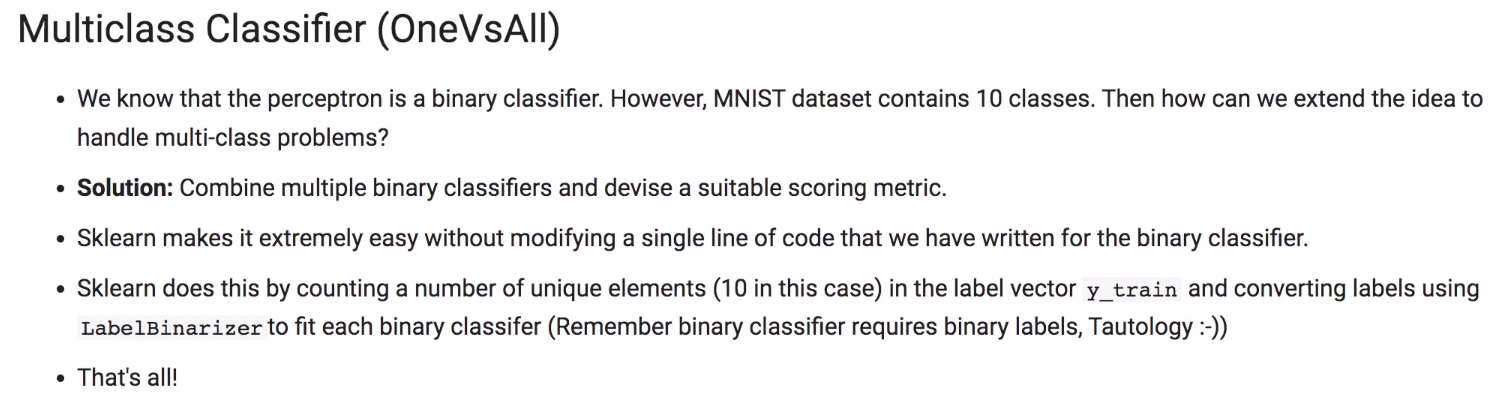

In [16]:
# Common imports
import numpy as np
import os, io, warnings

# sklearn imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

from pprint import pprint

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X = X.to_numpy()
y = y.to_numpy()

target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0}, Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features: 784
Minimum: 0.0, Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
clf = Perceptron(random_state=1729)

In [6]:
# let's use label binarizer
y_train_ovr = LabelBinarizer().fit_transform(y_train) # setting sparse_output=True in LabelBinarizer() improves efficiency

for i in range(10):
    print('{0}:{1}'.format(y_train[i], y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


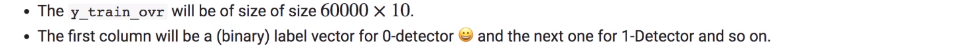

In [7]:
clf.fit(X_train, y_train)

Perceptron(random_state=1729)

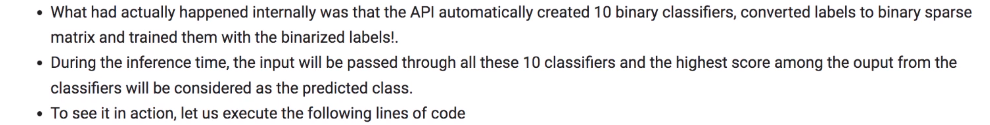

In [8]:
print('Shape of Weight matrix: {0} and bias vector: {1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix: (10, 784) and bias vector: (10,)


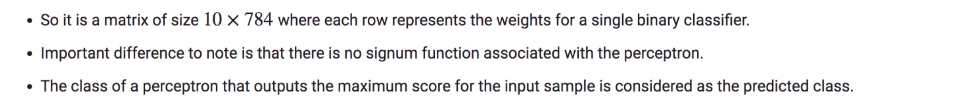

In [9]:
scores = clf.decision_function(X_train[6].reshape(1, -1))
print(scores)
print('The predicted class:', np.argmax(scores))

[[-33342028.   8100764.  -5743355.  -3783526. -12064800.  -6091786.
   -7294580.  -9695914.  -9097781.  -9763409.]]
The predicted class: 1


In [10]:
print('Predicted output:', clf.predict(X_train[0].reshape(1, -1)))

Predicted output: ['5']


In [11]:
# get the prediction for all training samples
y_hat = clf.predict(X_train)

In [12]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5923
           1       0.92      0.98      0.95      6742
           2       0.92      0.88      0.90      5958
           3       0.85      0.91      0.88      6131
           4       0.85      0.93      0.89      5842
           5       0.89      0.81      0.84      5421
           6       0.96      0.94      0.95      5918
           7       0.96      0.88      0.92      6265
           8       0.81      0.82      0.81      5851
           9       0.87      0.85      0.86      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000



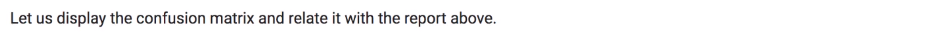

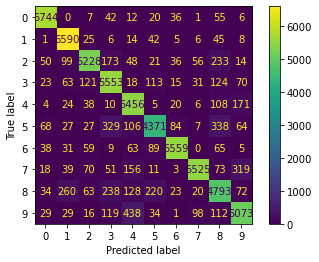

In [13]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format='.5g') # it returns matplotlin plot object

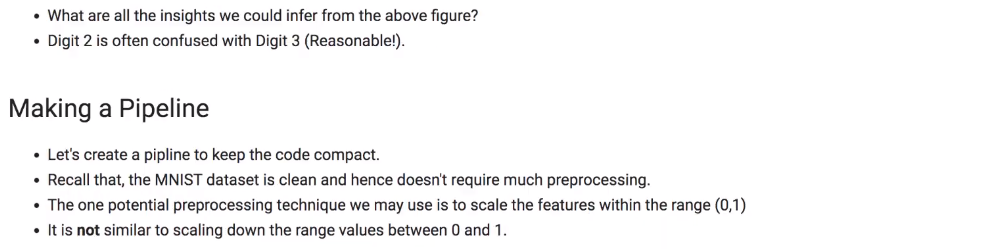

In [17]:
# create a list with named tuples
estimators = [
    ('std_scaler', MinMaxScaler()),
    ('bin_cf', Perceptron())
]
pipe = Pipeline(estimators)

In [18]:
# initilize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices with digit 0 image
indx_0 = np.where(y_train == '0')  # remeber original labels are of type str not int
# use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

In [19]:
pipe.fit(X_train, y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_cf', Perceptron())])

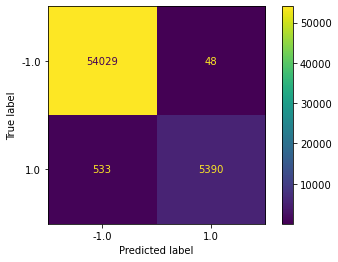

In [20]:
y_hat_train_0 = pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

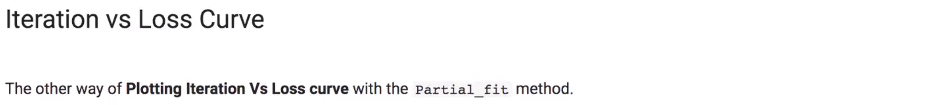

In [21]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000, random_state=2094)
Loss_clf1 = []
for i in range(iterations):
    bin_clf1.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_hat_0 = bin_clf1.decision_function(X_train)
    Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

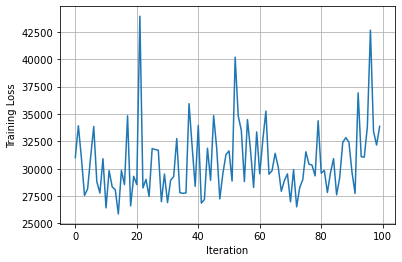

In [22]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

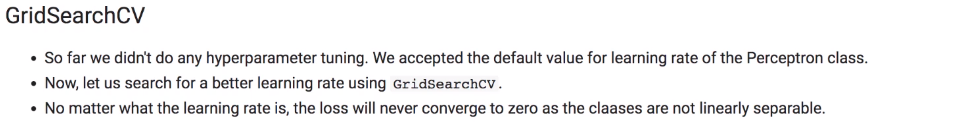

In [23]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2**n for n in range(1, 6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={'eta0': lr_grid}, scoring=scoring, cv=5)
bin_clf_gscv.fit(X_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [24]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.62762532, 1.61203351, 1.5618227 , 1.65819402, 1.69895782]),
 'mean_score_time': array([0.01839252, 0.01978607, 0.0183948 , 0.02018356, 0.02038665]),
 'mean_test_score': array([-0.02973333, -0.02973333, -0.02973333, -0.02973333, -0.02973333]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([1, 1, 1, 1, 1]),
 'split0_test_score': array([-0.03983333, -0.03983333, -0.03983333, -0.03983333, -0.03983333]),
 'split1_test_score': array([-0.02183333, -0.02183333, -0.02183333, -0.02183333, -0.02183333]),
 'split2_test_score': array([-0.021, -0.021, -0.021, -0.021, -0.021]),
 'split3_test_score': array([-0.02916667, -0.02916667, -0.02916667, -0.02916667, -0.02916667]),
 'spli

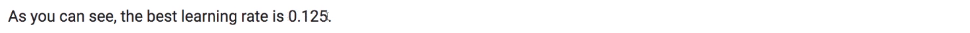

In [25]:
iterations = 100
Loss = []
best_bin_clf = Perceptron(max_iter=1000, random_state=2094, eta0=0.125)
for i in range(iterations):
    best_bin_clf.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_hat_0 = best_bin_clf.decision_function(X_train)
    Loss.append(hinge_loss(y_train_0, y_hat_0))

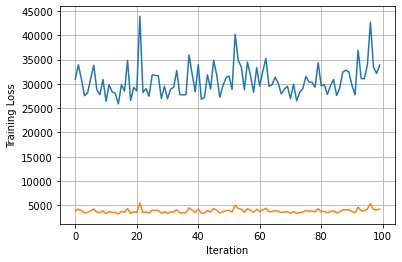

In [26]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1, label='eta0=1')
plt.plot(np.arange(iterations), Loss, label='eta0=0.125')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

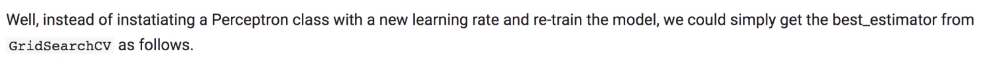

In [28]:
best_bin_clf = bin_clf_gscv.best_estimator_

In [30]:
y_hat_train_0 = bin_clf_gscv.predict(X_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99     54077
         1.0       0.99      0.85      0.91      5923

    accuracy                           0.98     60000
   macro avg       0.99      0.93      0.95     60000
weighted avg       0.98      0.98      0.98     60000



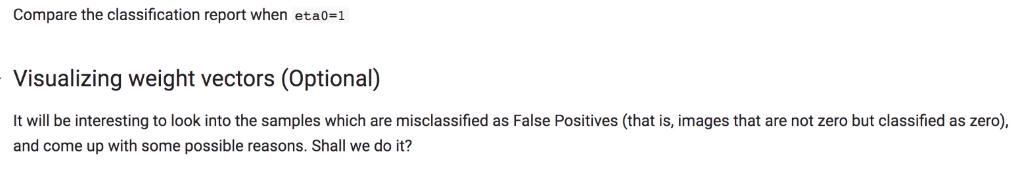

In [34]:
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)

print('Dimension of Weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of Weights w: (1, 784)
Bias: [-1696.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x0000026E117B4390>


In [35]:
# find the index of false positive samples
idx_n = np.where(y_train_0 == -1)             # index of true negative samples
idx_pred_p = np.where(y_hat_train_0 == 1)     # index of predicted positive smaples
idx_pred_n = np.where(y_hat_train_0 == -1)    # index of predicted negative smaples
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n, idx_pred_n)


C:\Program Files\KMSpico\temp\ipykernel_10764\3670338542.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


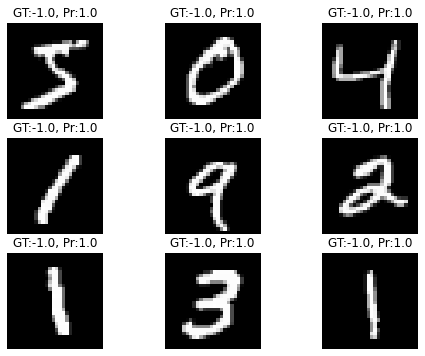

In [36]:
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))

fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"

for i in range(factor):
    index = idx_offset + i*factor
    for j in range(factor):
        ax[i, j].imshow(X_train[index+j].reshape(28,28), cmap='gray')
        ax[i, j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]), str(y_hat_train_0[idx_fp[index+j]])))
        ax[i, j].set_axis_off()

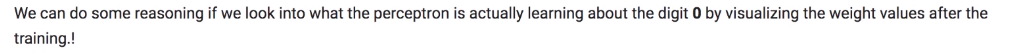

In [41]:
from matplotlib.colors import Normalize

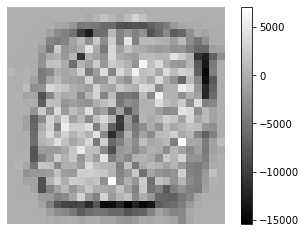

In [42]:
w = bin_clf.coef_
w_matrix = w.reshape(28, 28)
fig = plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

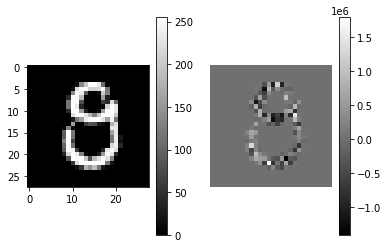

In [45]:
activation = w * X_train[idx_fp[0]].reshape(1,-1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx_fp[0]].reshape(28, 28), cmap='gray')
plt.colorbar()

# lin_out[lin_out < 0] = 0
plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [46]:
# input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

[1095673.]


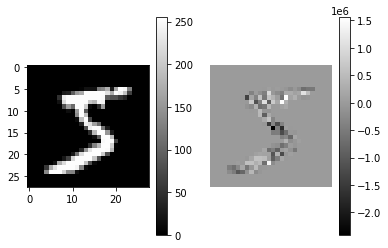

In [47]:
activation = w*X_train[idx_tn[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx_tn[0]].reshape(28, 28), cmap='gray')
plt.colorbar()

# lin_out[lin_out < 0] = 0
plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [48]:
# input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

[-16380576.]
